In [2]:
import datetime
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy as sp
import string
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

import nltk
# import scikitplot as skplt
import re, string
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
STOPWORDS = set(stopwords.words('russian'))
#list of special characters.You can use regular expressions too

# importing the PorterStemmer
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize,word_tokenize
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
#importing the CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import WordPunctTokenizer
from nltk.stem import SnowballStemmer
# from pymorphy2 import MorphAnalyzer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\150ho\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\150ho\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\150ho\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [4]:
from sklearn import metrics

In [5]:
import torch
import os
import pathlib
import numpy as np
import string
import re
import glob
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from collections import Counter
from torch.utils.data import DataLoader, Dataset, Subset

plt.style.use('ggplot')

In [6]:
# Set seed.
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [256]:
!nvidia-smi

"nvidia-smi" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [257]:
# with open('train.json', encoding='utf-8') as f:
#     data_train = json.load(f)
# with open('test.json', encoding='utf-8') as f:
#     data_test = json.load(f)

In [7]:
train = pd.read_json('train.json')
train

,text,id,sentiment
0,Досудебное расследование по факту покупки ЕНПФ...,1945,negative
1,Медики рассказали о состоянии пострадавшего му...,1957,negative
2,"Прошел почти год, как железнодорожным оператор...",1969,negative
3,По итогам 12 месяцев 2016 года на территории р...,1973,negative
4,Астана. 21 ноября. Kazakhstan Today - Агентств...,1975,negative
...,...,...,...
8258,"Как мы писали еще весной, для увеличения сбыта...",10312,positive
8259,Но молодой министр национальной экономики Биши...,10313,negative
8260,\n \nВ ЕНПФ назначен новый председатель правле...,10314,neutral
8261,В Алматы у отделения банка произошло нападение...,10315,negative


In [84]:
data_test = pd.read_json('test.json')
data_test

,text,id
0,"Как сообщает пресс-служба акимата Алматы, для ...",0
1,Казахстанские авиакомпании перевозят 250 тысяч...,1
2,На состоявшемся под председательством Касым-Жо...,2
3,В ОАЭ состоялись переговоры между казахстанско...,3
4,12 вагонов грузового поезда сошли с путей в Во...,4
...,...,...
2051,На официальной странице общественного движения...,2079
2052,"официальный курс – 330,55 тенге за Доллар США ...",2083
2053,"«Базовая ставка, которая сейчас составляет 12%...",2084
2054,На начальном этапе за неоплату парковки на при...,2087


In [9]:
class DatasetSeq(Dataset):
    def __init__(self):
#open file
        self.train = pd.read_json('train.json')
        train['sentiment'] = train['sentiment'].apply(lambda x: 1 if x == 'positive' else 0 if x == 'negative' else 2)
        # delete extra tag markup
        train1 = [x for x in self.train['text']]
    #init vocabs of tokens for encoding { token:  id}

        self.word_vocab = {} # {cat: 1, sat: 2, on: 3, mat: 4, '.': 5}
        self.char_vocab = {} # {c: 1, a: 2, t: 3, ' ': 4, s: 5}

        # Cat sat on mat. -> [1, 2, 3, 4, 5]
        # p    a  r  p pu -> [1, 2, 3, 1, 4]
        # chars  -> [1, 2, 3, 4, 5, 2, 3, 4]

        #init encoded sequences lists (processed data)
        self.encoded_sequences = []

        self.encoded_char_sequences = []
        # n=1 because first value is padding
        n_word = 1

        n_char = 1
        for line in train1:
            sequence = []

            chars = []
            for word in line.split(' '):
                if word != '':


                    if self.word_vocab.get(word) is None:
                        self.word_vocab[word] = n_word
                        n_word += 1

                    for char in word:
                        if self.char_vocab.get(char) is None:
                            self.char_vocab[char] = n_char
                            n_char += 1
                    sequence.append(self.word_vocab[word])

                    chars.append([self.char_vocab[char] for char in word])
            self.encoded_sequences.append(sequence)

            self.encoded_char_sequences.append(chars)

    def __len__(self):
        return len(self.encoded_sequences)

    def __getitem__(self, index):
        return {
            'data': self.encoded_sequences[index], # [1, 2, 3, 4, 6] len=5
            'char': self.encoded_char_sequences[index],# [[1,2,3], [4,5], [1,2], [2,6,5,4], []] len=5
            'target': train['sentiment'].loc[index], #  (1)
        }

In [10]:
dataset = DatasetSeq()

In [12]:
dataset.__getitem__(10)

{'data': [2206,
  571,
  2207,
  2208,
  70,
  2209,
  2210,
  2211,
  2212,
  2213,
  83,
  2214,
  2215,
  2216,
  2217,
  960,
  2218,
  2219,
  2220,
  808,
  2221,
  1051,
  2222,
  338,
  44,
  2223,
  2224,
  2225,
  2210,
  2211,
  2212,
  2226,
  2227,
  2213,
  2228,
  451,
  452,
  2229,
  24,
  355,
  2230,
  2231,
  651,
  83,
  2232,
  145,
  2233,
  960,
  2234,
  2235,
  808,
  2221,
  1051,
  2222,
  1051,
  2236,
  44,
  2237,
  2238,
  44,
  2239,
  917,
  2212,
  2213,
  761,
  3,
  1649,
  2240,
  145,
  2241,
  960,
  2242,
  24,
  2212,
  145,
  2233,
  960,
  2243,
  2244,
  2245,
  2246,
  2247,
  8,
  2248,
  44,
  467,
  468,
  2249,
  355,
  2250,
  2231,
  2251,
  1051,
  1275,
  2252,
  2253,
  2254,
  2255,
  2256,
  2257,
  1592,
  2258,
  2259,
  2260,
  2112,
  2261,
  60,
  2262,
  2263,
  591,
  2229,
  2264,
  24,
  2265,
  2266,
  2267,
  758,
  759,
  2268,
  230,
  44,
  2269,
  2270,
  2271,
  2272,
  145,
  2273,
  2274,
  960,
  2275,
  630,
 

In [263]:
def collate_fn(batch):
    data = []
    target = []
    for item in batch:
        data.append(torch.as_tensor(item['data']))
        target.append(torch.as_tensor(item['target']))
    # pad different length sequences
    data = pad_sequence(data, batch_first=True, padding_value=0)
    targets = torch.tensor(targets, dtype=torch.long)

    return {'data': data, 'target': target}

In [264]:
def collate_fn1(input_data):
    data = []
    chars = []
    targets = []
    max_len = 0
    for item in input_data:
        if len(item['data']) > max_len:
            max_len = len(item['data'])
        data.append(torch.as_tensor(item['data']))
        chars.append(item['char'])
        targets.append(torch.as_tensor(item['target']))
    chars_seq = [[torch.as_tensor([0]) for _ in range(len(input_data))] for _ in range(max_len)]
    for j in range(len(input_data)):
        for i in range(max_len):
            if len(chars[j]) > i:
                chars_seq[i][j] = torch.as_tensor(chars[j][i])
    for j in range(max_len):
        chars_seq[j] = pad_sequence(chars_seq[j], batch_first=True, padding_value=0)
    data = pad_sequence(data, batch_first=True, padding_value=0)
    targets = torch.tensor(targets, dtype=torch.long)
    return {'data': data, 'chars': chars_seq, 'target': targets}

In [14]:
#hyper params
vocab_size = len(dataset.word_vocab) + 1
n_classes = 3
n_chars = len(dataset.char_vocab) + 1
#TODO try to use other model parameters
emb_dim = 256 # поменял с 256 на 128
hidden = 256
char_hid = 64
char_emb = 32
n_epochs = 10
batch_size = 4
cuda_device = -1
device = f'cuda:{cuda_device}' if cuda_device != -1 else 'cpu'

In [15]:
device

'cpu'

In [41]:
class CharRNN_GRU(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim):
        super().__init__()
        self.char_emb = nn.Embedding(vocab_size, emb_dim)
        self.rnn = nn.GRU(emb_dim, hidden_dim, batch_first=True)

    def forward(self, x):
        emb = self.char_emb(x) # B x T x Emb_dim
        _, out = self.rnn(emb)
        # _: B x T x Hidden
        # out: 1 x B x Hidden

        return out.transpose(0, 1) # B x 1 x Hidden


In [42]:
from torch.nn import functional as F

class Attention_net(nn.Module):
    def __init__(self, temperature=1):
        super().__init__()
        self.temperature = temperature
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.Softmax(dim=2)
        
    def forward(self, q, k, v, mask=None):

        attn = torch.bmm(q, # B x T1 x V
                         k.transpose(1, 2), # B x T2 x V -> B x V x T2
                         ) # B x T1 x T2
        attn = attn / self.temperature

        if mask is not None:
            # print(attn.size(), mask.size())
            attn = attn.masked_fill(~mask, -np.inf)

        attn = self.softmax(attn)

        if mask is not None:
            attn = attn.masked_fill(~mask, 0.)

        attn = self.dropout(attn)
        output = torch.bmm(attn, v) # B x T1 x T2 @ B x T1 x V

        return output, attn

In [64]:
class RNN_GRU_CH_Attention(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, n_classes,
                 char_vocab, char_emb, char_hidden):
        super().__init__()
        #TODO try to use other RNN archicetures, f.e. RNN and LSTM
        self.word_emb = nn.Embedding(vocab_size, emb_dim)
        # batch_first = False: T x B x Vec
        # batch_first = True: B x T x Vec
        self.rnn = nn.GRU(emb_dim + char_hidden, hidden_dim, batch_first=True)
        self.clf = nn.Linear(hidden_dim*2, n_classes)
        self.do = nn.Dropout(0.2)
        self.hidden_dim = hidden_dim
        self.char_rnn = CharRNN_GRU(char_vocab, char_emb, char_hidden)
        self.attn = Attention_net()
       

    def forward(self, x, chars):
        emb = self.word_emb(x)
        char_features = [self.char_rnn(c.to(x.device)) for c in chars]
        char_features = torch.cat(char_features, dim=1) # конкатенация по времени B x T x Char_hid
        emb = torch.cat((emb, char_features), dim=-1) # конкатенация векторов
#         print(emb.size())
        output, context = self.rnn(emb)
        context = context.permute(1, 0, 2)
#         print(output.size(), context.size())
        attn_output, _ = self.attn(output, context, context)
        out = self.do(torch.cat((output, attn_output), dim=-1))
        out = out.max(dim=1)[0]
        out = self.clf(out)


        return out

In [373]:
model1 = RNN_GRU_CH_Attention(vocab_size, emb_dim, hidden, n_classes, n_chars, char_emb, char_hid).to(device)
model1.train()
optim1 = torch.optim.Adam(model1.parameters(), lr=0.001)
loss_func1 = nn.CrossEntropyLoss()

In [374]:
print(model1)
# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model1.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model1.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.\n")

RNN_GRU_CH_Attention(
  (word_emb): Embedding(324758, 256)
  (rnn): GRU(320, 256, batch_first=True)
  (clf): Linear(in_features=512, out_features=3, bias=True)
  (do): Dropout(p=0.2, inplace=False)
  (char_rnn): CharRNN_GRU(
    (char_emb): Embedding(315, 32)
    (rnn): GRU(32, 64, batch_first=True)
  )
  (attn): Attention_net(
    (dropout): Dropout(p=0.1, inplace=False)
    (softmax): Softmax(dim=2)
  )
)
83,612,387 total parameters.
83,612,387 training parameters.



In [375]:
dataloader1 = DataLoader(dataset,
                            batch_size,
                            shuffle=True,
                            collate_fn=collate_fn1,
                            drop_last = True,
                            )

In [376]:
batch = next(iter(dataloader1))
predict = model1(batch['data'].to(device), batch['chars'])
labl = batch['target'].to(device)
loss = loss_func1(predict, labl)
preds = torch.argmax(predict, 1)
preds, labl, loss

torch.Size([4, 1117, 320])
torch.Size([4, 1117, 256]) torch.Size([4, 1, 256])


(tensor([0, 0, 0, 0]),
 tensor([1, 2, 1, 2]),
 tensor(1.3310, grad_fn=<NllLossBackward0>))

In [ ]:
class RNN_GRU_CH(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, n_classes,
                 char_vocab, char_emb, char_hidden):
        super().__init__()
        #TODO try to use other RNN archicetures, f.e. RNN and LSTM
        self.word_emb = nn.Embedding(vocab_size, emb_dim)
        # batch_first = False: T x B x Vec
        # batch_first = True: B x T x Vec
        self.rnn = nn.GRU(emb_dim + char_hidden, hidden_dim, batch_first=True)
        self.clf = nn.Linear(hidden_dim, n_classes)
        self.do = nn.Dropout(0.2)
        self.hidden_dim = hidden_dim
        self.char_rnn = CharRNN_GRU(char_vocab, char_emb, char_hidden)

    def forward(self, x, chars):
        emb = self.word_emb(x)
        char_features = [self.char_rnn(c.to(x.device)) for c in chars]
        char_features = torch.cat(char_features, dim=1) # конкатенация по времени B x T x Char_hid
        emb = torch.cat((emb, char_features), dim=-1) # конкатенация векторов
        hidden, _ = self.rnn(emb)
        x = self.do(hidden)
        x = x.max(dim=1)[0]
        out = self.clf(x)

        return out

In [359]:
model = RNN_GRU_CH(vocab_size, emb_dim, hidden, n_classes, n_chars, char_emb, char_hid).to(device)
model.train()
optim = torch.optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

NameError: name 'RNN_GRU_CH' is not defined

In [360]:
print(model)
# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.\n")

NameError: name 'model' is not defined

In [31]:
dataloader = DataLoader(dataset,
                            batch_size,
                            shuffle=True,
                            collate_fn=collate_fn1,
                            drop_last = True,
                            )

In [ ]:
for epoch in range(n_epochs):

    for i, batch in enumerate(dataloader):
        optim.zero_grad()

        predict = model(batch['data'].to(device), batch['chars'])
        labl = batch['target'].to(device).view(-1)
        loss = loss_func(predict.view(-1, n_classes), labl)

        loss.backward()
        optim.step()
        if i % 100 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')

    torch.save(model.state_dict(), f'./rnn_chkpt_{epoch}.pth')

GRUch_train_loss = loss.item()

print(GRUch_train_loss)

tensor(1.0584, grad_fn=<NllLossBackward0>)
epoch: 0, step: 0, loss: 1.0584057569503784
tensor(1.0687, grad_fn=<NllLossBackward0>)
tensor(1.0742, grad_fn=<NllLossBackward0>)
tensor(0.8604, grad_fn=<NllLossBackward0>)
tensor(0.9819, grad_fn=<NllLossBackward0>)
tensor(1.1232, grad_fn=<NllLossBackward0>)


In [ ]:
def find_longest_length(data):
    """
    Find the longest review length in the entire training set.

    :param data.

    Returns:
        max_len: Longest review length.
    """
    max_length = 0
    for text in data['text']:
            text = re.sub('<[^>]+>+', '', text)
            corpus = [
                word for word in text.split()
            ]
            if len(corpus) > max_length:
                max_length = len(corpus)
    return max_length

longest_test = find_longest_length(data_test)
longest_train = find_longest_length(data_train)
print(f"Longest review length test: {longest_test} words")
print(f"Longest review length train: {longest_train} words")

Longest review length test: 41062 words
Longest review length train: 48146 words


In [ ]:
def find_avg_sentence_length(data):
    """
    Find the average sentence in the entire training set.

    :param data['text'].

    Returns:
        avg_len: Average length.
    """
    sentence_lengths = []
    for text in data['text']:
            # Remove <br> tags.
            text = re.sub('<[^>]+>+', '', text)
            corpus = [
                word for word in text.split()
            ]
            sentence_lengths.append(len(corpus))
    return sum(sentence_lengths)/len(sentence_lengths)

average_length_test = find_avg_sentence_length(data_test)
average_length_train = find_avg_sentence_length(data_train)
print(f"Average review length test: {average_length_test} words")
print(f"Average review length train: {average_length_train} words")

Average review length test: 533.6001945525292 words
Average review length train: 511.68001936342733 words


In [ ]:
# Max sentence length to consider from a text file.
# If a sentence is shorter than this, it will be padded.
# We can use the max sentence length from the dataset or any
# reasonnable choice. 232.76 is the average length without the <br> tags.
# 236.70 is the average lenght with the <br> tags.
MAX_LEN = int(average_length_train)
# Use these many top words from the dataset. If -1, use all words.
NUM_WORDS = -1 # Vocabulary size.
# Batch size.
BATCH_SIZE = 128
VALID_SPLIT = 0.20

In [ ]:
def find_word_frequency(data, most_common=None):
    """
    Create a list of tuples of the following format,
    [('ho', 2), ('hello', 1), ("let's", 1), ('go', 1)]
    where the number represents the frequency of occurance of
    the word in the entire dataset.

    :param data['text'].
    :param most_common: Return these many top words from the dataset.
        If `most_common` is None, return all. If `most_common` is 3,
        returns the top 3 tuple pairs in the list.

    Returns:
        sorted_words: A list of tuple containing each word and it's
        frequency of the format ('ho', 2), ('hello', 1), ...]
    """
    # Add all the words in the entire dataset to `corpus` list.
    corpus = []
    for text in data['text']:
            # Remove <br> tags.
            text = re.sub('<[^>]+>+', '', text)
            corpus.extend([
                word for word in text.split()
            ])
    count_words = Counter(corpus)
    # Create a dictionary with the most common word in the corpus
    # at the beginning.
    # `word_frequency` will be like
    word_frequency = count_words.most_common(n=most_common) # Returns all if n is `None`.
    return word_frequency

In [ ]:
def word2int(input_words, num_words):
    """
    Create a dictionary of word to integer mapping for each unique word.

    :param input_words: A list of tuples containing the words and
        theiry frequency. Should be of the following format,
        [('ho', 2), ('hello', 1), ("let's", 1), ('go', 1)]
    :param num_words: Number of words to use from the `input_words` list
        to create the mapping. If -1, use all words in the dataset.

    Returns:
        int_mapping: A dictionary of word and a integer mapping as
            key-value pair. Example, {'Hello,': 1, 'the': 2, 'let': 3}
    """

    if num_words > -1:
        int_mapping = {
            w:i+1 for i, (w, c) in enumerate(input_words) if i <= num_words - 1 # -1 to avoid getting (num_words + 1) integer mapping.
        }
    else:
        int_mapping = {w:i+1 for i, (w, c) in enumerate(input_words)}
    return int_mapping

In [ ]:
class NLPClassificationDataset(Dataset):
    def __init__(self, data, word_frequency, int_mapping, max_len):
        self.word_frequency = word_frequency
        self.int_mapping = int_mapping
        self.data = data
        self.max_len = max_len

    def standardize_text(self, input_text):
        # Convert everything to lower case.
        text = input_text.lower()
        # If the text contains HTML tags, remove them.
        text = re.sub('<[^>]+>+', '', text)
        # Remove punctuation marks using `string` module.
        # According to `string`, the following will be removed,
        # '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
        text = ''.join([character for character in text if character not in string.punctuation])
        text = " ".join([word for word in text.split() if word not in STOPWORDS])
#         text = " ".join(ps.stem(lemmatizer.normal_forms(word)[0]) for word in text.split())
        return text

    def return_int_vector(self, int_mapping, data):
        """
        Assign an integer to each word and return the integers in a list.
        """

        text = self.standardize_text(data['text'])
        corpus = [word for word in text.split()]
        # Each word is replaced by a specific integer.
        int_vector = [int_mapping[word] for word in text.split() if word in int_mapping]
        return int_vector

    def pad_features(self, int_vector, max_len):
        """
        Return features of `int_vector`, where each vector is padded
        with 0's or truncated to the input seq_length. Return as Numpy
        array.
        """
        features = np.zeros((1, max_len), dtype = int)
        if len(int_vector) <= max_len:
            zeros = list(np.zeros(max_len - len(int_vector)))
            new = zeros + int_vector
        else:
            new = int_vector[: max_len]
        features = np.array(new)
        return features

    def encode_labels(self, data):

        if  data['sentiment'] == 'positive':
            int_label = 1
        elif data['sentiment'] == 'negative':
            int_label = 0
        else:
            int_label = 2
        return int_label

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        file = self.data.loc[idx]
        int_vector = self.return_int_vector(self.int_mapping, file)
        padded_features = self.pad_features(int_vector, self.max_len)
        label = self.encode_labels(file)
        return {
            'text': torch.tensor(padded_features, dtype=torch.int32),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
# Get the frequency of all unqiue words in the dataset.
word_frequency = find_word_frequency(data_train)
# Assign a specific intenger to each word.
int_mapping = word2int(word_frequency, num_words=NUM_WORDS)

In [ ]:
print(len(int_mapping))

290012


In [ ]:
dataset = NLPClassificationDataset(
    data_train, word_frequency, int_mapping, MAX_LEN
)

dataset_size = len(dataset)
# Calculate the validation dataset size.
valid_size = int(VALID_SPLIT*dataset_size)
# Radomize the data indices.
indices = torch.randperm(len(dataset)).tolist()
# Training and validation sets.
dataset_train = Subset(dataset, indices[:-valid_size])
dataset_valid = Subset(dataset, indices[-valid_size:])

dataset_test = NLPClassificationDataset(
    data_train, word_frequency, int_mapping, MAX_LEN
)

# dataset_valid = NLPClassificationDataset()
print(f"Number of training samples: {len(dataset_train)}")
print(f"Number of validation samples: {len(dataset_valid)}")
print(f"Number of test samples: {len(dataset_test)}")

Number of training samples: 6611
Number of validation samples: 1652
Number of test samples: 8263


In [ ]:
print(dataset_train[0])

{'text': tensor([242592,  14004,   4057,    384,    248,  56020,   2796,   1451,   1182,
         21954,   8660, 234795,  39772,  21756,  31837,   8475,   2793,    150,
           462,    186,   3761,   9864,  43017,  25200,   6902,   4177,     12,
         57104,  32009,    975,  56020,   2796,   1451,  11492, 146104,   2234,
         35372, 234798,  15370,  64110, 234800, 234801, 150641, 126207,  79081,
        234803,  38927, 234804, 145261, 234806, 234807, 234808, 234809,   5259,
         13598, 146105, 234810,  98161, 234811, 234813,    732, 234814, 234815,
           223,   6754,  66748,   2793, 234816, 210494, 234818,  15444,  15289,
         51571, 234819, 125621, 234820, 120212,   2793,   1451,  11581,   5701,
          6431, 234821,  17018,   3315, 234823,  28946,    650,    488,  55072,
         48026,  16931,   1069,   3985,  44789,   1237, 234824,  15642,   3150,
         18550,  73977, 234825,    257,  20773,    950,   4464,  35079,  20773,
           669,   4177,     12,

In [ ]:
# Integer to word mapping for the training dataset.
int2word_train = {value: key for key, value in int_mapping.items()}

In [ ]:
# Print a sample input and its label.
inputs = ''
for x in dataset_train[0]['text']:
    if x != 0:
        inputs += ' ' + int2word_train[int(x)]
print(inputs)
print('#'*25)
if int(dataset_train[0]['label']) == 1:
    label = 'positive'
elif int(dataset_train[0]['label']) == 0:
    label = 'negative'
else:
    label = 'neutral'
print('Label:', label)

 актау последнюю пятницу сентября территории актауского морского порта самого раннего утра царило радостное оживление готовились приему гостей которых свой день рождения пригласил морпорт исполнилось целых 53 года праздничное настроение работников актауского морского порта смогла испортить столь редкая пасмурная погода красочно оформленная импровизированная сцена веселая музыка накрытые столы кулинарными заботливо приготовленными искусными хозяйками сотрудницами подразделений морпорта грозный повелитель морей океанов обходящий вместе изящной русалочкой свои владения встречающие гостей юнги матросы отдающие короткие четкие приказы капитаны парадных кителях переносили гостей порта атмосферу праздника ожидания торжественности предстоящего события полувековой юбилей каждый человек оглядываясь пройденный жизненный путь начинает подводить итоги перелистывая страницы трудовой биографии вспоминая зигзаги своей судьбы несмотря отличие человеческой судьбы жизни 53 года предприятия это возраст ра

In [ ]:
train_loader = DataLoader(
    dataset_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4
)

valid_loader = DataLoader(
    dataset_valid,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4
)

test_loader = DataLoader(
    dataset_test,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4
)

In [ ]:
# def binary_accuracy(labels, outputs, train_running_correct):
#     # As the outputs are currently logits.
#     outputs = torch.sigmoid(outputs)
#     running_correct = 0
#     for i, label in enumerate(labels):
#         if label < 0.5 and outputs[i] < 0.5:
#             running_correct += 1
#         elif label >= 0.5 and outputs[i] >= 0.5:
#             running_correct += 1
#     return running_correct

In [ ]:
# def acc(pred,label):
#     pred = torch.round(pred.squeeze())
#     print(torch.sum(pred == label.squeeze()).item())
#     return torch.sum(pred == label.squeeze()).item()

In [ ]:
classes = 3
# for i in range(classes):
#   print(i)

In [ ]:
# Training function.
def train(model, trainloader, optimizer, criterion, device):
    model.train()
    print('Training')
    y_true_t, y_pred_t = [], []
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    # train_class_correct = list(0. for i in range(classes))
    # train_class_total = list(0. for i in range(classes))
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        inputs, labels = data['text'], data['label']
        # print('inputs', inputs)
        # print('labels', labels)
        inputs = inputs.to(device)
        labels = labels.to(device).view(-1)
        optimizer.zero_grad()
        # Forward pass.
        outputs1 = model(inputs)
        outputs = outputs1.view(-1, classes)
        # print('outputs1', outputs1)
        # print('outputs', outputs)
        # Calculate the loss.
        loss = criterion(outputs1, labels)
        train_running_loss += loss.item()
        preds = torch.argmax(outputs1, 1)
        # print('preds', preds)
        train_running_correct += (preds == labels).sum().item()
        # print('train_running_correct', train_running_correct)
        # correct  = (preds == labels).squeeze()
        # print('correct', correct)
        # for a in range(len(preds)):
        #         label = labels[a]
        #         print(label)
        #         print(correct[a])
        #         train_class_correct[label] += correct[a].item()
        #         train_class_total[label] += 1
        # Backpropagation.
        loss.backward()
        # Update the optimizer parameters.
        optimizer.step()

        y_true_t.extend([int(item) for item in labels])
        y_pred_t.extend([int(item) for item in preds])

    print('train_running_correct', train_running_correct)
    # Loss and accuracy for the complete epoch.
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    epoch_accuracy = metrics.accuracy_score(y_true_t, y_pred_t)

    # for i in range(classes):
    #     print(f"Accuracy of class {classes[i]}: {100*train_class_correct[i]/class_total[i]}")
    # print('\n')

    return epoch_loss, epoch_acc, epoch_accuracy

In [ ]:
# Validation function.
def validate(model, testloader, criterion, device):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    y_true_v, y_pred_v = [], []
    # val_class_correct = list(0. for i in range(classes))
    # val_class_total = list(0. for i in range(classes))

    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            inputs, labels = data['text'], data['label']
            inputs = inputs.to(device)
            labels = labels.to(device).view(-1)
            # Forward pass.
            outputs1 = model(inputs)
            outputs = outputs1.view(-1, classes)

            # Calculate the loss.
            loss = criterion(outputs, labels)

            valid_running_loss += loss.item()
            preds = torch.argmax(outputs1,1)
            valid_running_correct += (preds == labels).sum().item()
            # correct  = (preds == labels).squeeze()
            # for a in range(len(preds)):
            #     label = labels[a]
            #     # print(label)
            #     val_class_correct[label] += correct[a].item()
            #     val_class_total[label] += 1

            y_true_v.extend([int(item) for item in labels])
            y_pred_v.extend([int(item) for item in preds])

    # Loss and accuracy for the complete epoch.
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    epoch_accuracy = metrics.accuracy_score(y_true_v, y_pred_v)


    # for i in range(classes):
    #     print(f"Accuracy of class {classes[i]}: {100*val_class_correct[i]/val_class_total[i]}")
    # print('\n')



    return epoch_loss, epoch_acc, epoch_accuracy

In [ ]:
 class SimpleEmbedding(nn.Module):
    def __init__(self, vocab_size, max_len, embed_dim, classes):
        super(SimpleEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim=embed_dim)
        self.rnn = nn.GRU(embed_dim, max_len, batch_first=True)
        self.linear1 = nn.Linear(max_len, classes)
        self.hidden_dim = max_len
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.rnn(x)
        x = self.dropout(x)
        x = x.max(dim=1)[0]
        # x = x.view(x.size(0), -1)
        out = self.linear1(x)
        return out

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
EMBED_DIM = 50
model = SimpleEmbedding(
    len(int_mapping)+1,
    MAX_LEN,
    EMBED_DIM, classes
).to(device)

In [ ]:
print(model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    model.parameters(),
    lr=0.001,
)
# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.\n")

SimpleEmbedding(
  (embedding): Embedding(290013, 50)
  (rnn): GRU(50, 511, batch_first=True)
  (linear1): Linear(in_features=511, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
15,365,265 total parameters.
15,365,265 training parameters.



In [ ]:
epochs = 50
# Lists to keep track of losses and accuracies.
train_loss, valid_loss = [], []
train_acc, valid_acc, t_acc, v_acc = [], [], [], []
# Start the training.
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss,  train_epoch_acc, t_epoch_acc = train(model, train_loader,
                                            optimizer, criterion, device)
    valid_epoch_loss, valid_epoch_acc, v_epoch_acc = validate(model, valid_loader,
                                                criterion, device)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    t_acc.append(t_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    v_acc.append(v_epoch_acc)
    print(f"Training loss: {train_epoch_loss}, training acc: {train_epoch_acc}, train acc: {t_epoch_acc}")
    print(f"Validation loss: {valid_epoch_loss}, validation acc: {valid_epoch_acc}, val acc: {v_epoch_acc}")

    # Save model.
    torch.save(model, f'./model_{epoch}.pth')
    print('-'*50)

[INFO]: Epoch 1 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 5766
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.3240922334102484, training acc: 87.21827257600968, train acc: 0.8721827257600968
Validation loss: 0.7492438875711881, validation acc: 64.10411622276028, val acc: 0.6410411622276029
--------------------------------------------------
[INFO]: Epoch 2 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 5891
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.2830848295528155, training acc: 89.10906065648162, train acc: 0.8910906065648162
Validation loss: 0.7648049730520982, validation acc: 63.37772397094431, val acc: 0.6337772397094431
--------------------------------------------------
[INFO]: Epoch 3 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6014
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.22594033210323408, training acc: 90.96959612766601, train acc: 0.9096959612766601
Validation loss: 0.7621089632694538, validation acc: 63.74092009685231, val acc: 0.637409200968523
--------------------------------------------------
[INFO]: Epoch 4 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6039
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.21058774481599146, training acc: 91.34775374376039, train acc: 0.913477537437604
Validation loss: 0.7718369777386005, validation acc: 63.31719128329297, val acc: 0.6331719128329297
--------------------------------------------------
[INFO]: Epoch 5 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6100
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.19079164745142826, training acc: 92.2704583270307, train acc: 0.922704583270307
Validation loss: 0.7693717021208543, validation acc: 62.95399515738499, val acc: 0.6295399515738499
--------------------------------------------------
[INFO]: Epoch 6 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6134
Validation


  0%|          | 0/13 [00:01<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7aa245657760>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7aa245657760>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Training loss: 0.17791992526214856, training acc: 92.78475268491907, train acc: 0.9278475268491907
Validation loss: 0.7771432858247024, validation acc: 63.983050847457626, val acc: 0.6398305084745762
--------------------------------------------------
[INFO]: Epoch 7 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6166
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.15820433457310384, training acc: 93.26879443351989, train acc: 0.9326879443351989
Validation loss: 0.7808234370671786, validation acc: 63.74092009685231, val acc: 0.637409200968523
--------------------------------------------------
[INFO]: Epoch 8 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6179
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.14986953096320996, training acc: 93.46543639388896, train acc: 0.9346543639388897
Validation loss: 0.7822449207305908, validation acc: 63.74092009685231, val acc: 0.637409200968523
--------------------------------------------------
[INFO]: Epoch 9 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6211
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.14123221329198435, training acc: 93.9494781424898, train acc: 0.939494781424898
Validation loss: 0.8012828597655663, validation acc: 63.983050847457626, val acc: 0.6398305084745762
--------------------------------------------------
[INFO]: Epoch 10 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6218
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.13207102165772364, training acc: 94.05536227499623, train acc: 0.9405536227499622
Validation loss: 0.8594957269155062, validation acc: 63.01452784503632, val acc: 0.6301452784503632
--------------------------------------------------
[INFO]: Epoch 11 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6193
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.13617435885736576, training acc: 93.67720465890183, train acc: 0.9367720465890182
Validation loss: 0.7866118275202237, validation acc: 64.34624697336562, val acc: 0.6434624697336562
--------------------------------------------------
[INFO]: Epoch 12 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6230
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.12839322093014532, training acc: 94.23687793072153, train acc: 0.9423687793072153
Validation loss: 0.8221564155358535, validation acc: 63.256658595641646, val acc: 0.6325665859564165
--------------------------------------------------
[INFO]: Epoch 13 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6234
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.14044161097934613, training acc: 94.29738314929664, train acc: 0.9429738314929663
Validation loss: 0.8255780614339389, validation acc: 63.49878934624697, val acc: 0.6349878934624698
--------------------------------------------------
[INFO]: Epoch 14 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6219
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.13237219490110874, training acc: 94.07048857964, train acc: 0.9407048857964
Validation loss: 0.8162423830765945, validation acc: 64.16464891041163, val acc: 0.6416464891041163
--------------------------------------------------
[INFO]: Epoch 15 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6242
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.12630270700901747, training acc: 94.41839358644684, train acc: 0.9441839358644684
Validation loss: 0.8038501877051133, validation acc: 64.64891041162227, val acc: 0.6464891041162227
--------------------------------------------------
[INFO]: Epoch 16 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6264
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.11085002647282985, training acc: 94.7511722886099, train acc: 0.947511722886099
Validation loss: 0.8333265414604774, validation acc: 64.34624697336562, val acc: 0.6434624697336562
--------------------------------------------------
[INFO]: Epoch 17 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6236
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.11782296184593669, training acc: 94.32763575858418, train acc: 0.9432763575858418
Validation loss: 0.8249690853632413, validation acc: 64.16464891041163, val acc: 0.6416464891041163
--------------------------------------------------
[INFO]: Epoch 18 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6261
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.11073025785243282, training acc: 94.70579337467856, train acc: 0.9470579337467857
Validation loss: 0.825572825395144, validation acc: 64.64891041162227, val acc: 0.6464891041162227
--------------------------------------------------
[INFO]: Epoch 19 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6272
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.10455052504459253, training acc: 94.8721827257601, train acc: 0.948721827257601
Validation loss: 0.9000442853340735, validation acc: 63.19612590799032, val acc: 0.6319612590799032
--------------------------------------------------
[INFO]: Epoch 20 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6268
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.10657201198717722, training acc: 94.811677507185, train acc: 0.94811677507185
Validation loss: 0.8941629116351788, validation acc: 63.80145278450363, val acc: 0.6380145278450363
--------------------------------------------------
[INFO]: Epoch 21 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6263
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.10552375785146768, training acc: 94.73604598396612, train acc: 0.9473604598396612
Validation loss: 0.9002616222088153, validation acc: 63.01452784503632, val acc: 0.6301452784503632
--------------------------------------------------
[INFO]: Epoch 22 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6258
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.10493858337688905, training acc: 94.66041446074725, train acc: 0.9466041446074724
Validation loss: 0.8541622207714961, validation acc: 64.10411622276028, val acc: 0.6410411622276029
--------------------------------------------------
[INFO]: Epoch 23 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6271
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.10332776233553886, training acc: 94.85705642111633, train acc: 0.9485705642111633
Validation loss: 0.862233579158783, validation acc: 64.04358353510897, val acc: 0.6404358353510896
--------------------------------------------------
[INFO]: Epoch 24 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6289
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.10402328958018468, training acc: 95.12932990470429, train acc: 0.9512932990470429
Validation loss: 0.89425128698349, validation acc: 63.256658595641646, val acc: 0.6325665859564165
--------------------------------------------------
[INFO]: Epoch 25 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6294
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.0943135955872444, training acc: 95.20496142792317, train acc: 0.9520496142792316
Validation loss: 0.8605804810157189, validation acc: 64.40677966101694, val acc: 0.6440677966101694
--------------------------------------------------
[INFO]: Epoch 26 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6272
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.09823595273953217, training acc: 94.8721827257601, train acc: 0.948721827257601
Validation loss: 0.8798047579251803, validation acc: 64.58837772397095, val acc: 0.6458837772397095
--------------------------------------------------
[INFO]: Epoch 27 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6291
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.0966710730527456, training acc: 95.15958251399184, train acc: 0.9515958251399184
Validation loss: 0.8811808962088364, validation acc: 64.28571428571429, val acc: 0.6428571428571429
--------------------------------------------------
[INFO]: Epoch 28 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6313
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.09759956304557048, training acc: 95.4923612161549, train acc: 0.954923612161549
Validation loss: 0.8890258715702937, validation acc: 63.31719128329297, val acc: 0.6331719128329297
--------------------------------------------------
[INFO]: Epoch 29 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6302
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.09816565801604436, training acc: 95.32597186507337, train acc: 0.9532597186507337
Validation loss: 0.8836751305139982, validation acc: 63.68038740920097, val acc: 0.6368038740920097
--------------------------------------------------
[INFO]: Epoch 30 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6304
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.09865250452779807, training acc: 95.35622447436091, train acc: 0.9535622447436092
Validation loss: 0.894585329752702, validation acc: 63.861985472154956, val acc: 0.6386198547215496
--------------------------------------------------
[INFO]: Epoch 31 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6297
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.08935775228131276, training acc: 95.2503403418545, train acc: 0.9525034034185449
Validation loss: 0.8640606311651376, validation acc: 64.16464891041163, val acc: 0.6416464891041163
--------------------------------------------------
[INFO]: Epoch 32 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6301
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.09212575394373673, training acc: 95.31084556042958, train acc: 0.9531084556042959
Validation loss: 0.9114218583473792, validation acc: 63.861985472154956, val acc: 0.6386198547215496
--------------------------------------------------
[INFO]: Epoch 33 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6319
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.08915186078789142, training acc: 95.58311904401755, train acc: 0.9558311904401755
Validation loss: 0.9009591616117038, validation acc: 63.80145278450363, val acc: 0.6380145278450363
--------------------------------------------------
[INFO]: Epoch 34 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6306
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.10588955492354356, training acc: 95.38647708364847, train acc: 0.9538647708364847
Validation loss: 0.9046059342531058, validation acc: 63.983050847457626, val acc: 0.6398305084745762
--------------------------------------------------
[INFO]: Epoch 35 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6303
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.10335475034438647, training acc: 95.34109816971714, train acc: 0.9534109816971714
Validation loss: 0.9102244698084317, validation acc: 63.80145278450363, val acc: 0.6380145278450363
--------------------------------------------------
[INFO]: Epoch 36 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6320
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.09129570768429683, training acc: 95.59824534866132, train acc: 0.9559824534866133
Validation loss: 0.9151040361477778, validation acc: 63.861985472154956, val acc: 0.6386198547215496
--------------------------------------------------
[INFO]: Epoch 37 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6294
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.09312129088749106, training acc: 95.20496142792317, train acc: 0.9520496142792316
Validation loss: 0.9017544021973243, validation acc: 63.983050847457626, val acc: 0.6398305084745762
--------------------------------------------------
[INFO]: Epoch 38 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6323
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.08624189314790644, training acc: 95.64362426259265, train acc: 0.9564362426259265
Validation loss: 0.9092356012417719, validation acc: 64.76997578692493, val acc: 0.6476997578692494
--------------------------------------------------
[INFO]: Epoch 39 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6316
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.08653207295216046, training acc: 95.53774013008622, train acc: 0.9553774013008622
Validation loss: 0.9104212751755347, validation acc: 64.58837772397095, val acc: 0.6458837772397095
--------------------------------------------------
[INFO]: Epoch 40 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6307
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.08533572151254003, training acc: 95.40160338829224, train acc: 0.9540160338829224
Validation loss: 0.9316680935712961, validation acc: 64.04358353510897, val acc: 0.6404358353510896
--------------------------------------------------
[INFO]: Epoch 41 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6315
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.08245096072697869, training acc: 95.52261382544245, train acc: 0.9552261382544245
Validation loss: 0.8998640638131362, validation acc: 63.49878934624697, val acc: 0.6349878934624698
--------------------------------------------------
[INFO]: Epoch 42 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6343
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.07872832315759017, training acc: 95.94615035546816, train acc: 0.9594615035546816
Validation loss: 0.9609218606582055, validation acc: 64.22518159806295, val acc: 0.6422518159806295
--------------------------------------------------
[INFO]: Epoch 43 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6320
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.0844598887488246, training acc: 95.59824534866132, train acc: 0.9559824534866133
Validation loss: 0.9044857025146484, validation acc: 64.22518159806295, val acc: 0.6422518159806295
--------------------------------------------------
[INFO]: Epoch 44 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6327
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.07883988747086662, training acc: 95.70412948116775, train acc: 0.9570412948116775
Validation loss: 0.9051436139987066, validation acc: 63.13559322033898, val acc: 0.6313559322033898
--------------------------------------------------
[INFO]: Epoch 45 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6346
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.08291297893111522, training acc: 95.99152926939949, train acc: 0.9599152926939949
Validation loss: 0.9663624213292048, validation acc: 63.68038740920097, val acc: 0.6368038740920097
--------------------------------------------------
[INFO]: Epoch 46 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6315
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.07559726788447453, training acc: 95.52261382544245, train acc: 0.9552261382544245
Validation loss: 0.9038556080598098, validation acc: 63.922518159806295, val acc: 0.639225181598063
--------------------------------------------------
[INFO]: Epoch 47 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6345
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.07202239112498668, training acc: 95.97640296475572, train acc: 0.9597640296475571
Validation loss: 0.9720716843238244, validation acc: 62.71186440677966, val acc: 0.6271186440677966
--------------------------------------------------
[INFO]: Epoch 48 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6331
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.08123091088894469, training acc: 95.76463469974286, train acc: 0.9576463469974286
Validation loss: 0.9368416391886197, validation acc: 64.5278450363196, val acc: 0.6452784503631961
--------------------------------------------------
[INFO]: Epoch 49 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6313
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.07947494698545107, training acc: 95.4923612161549, train acc: 0.954923612161549
Validation loss: 0.9554953712683457, validation acc: 64.10411622276028, val acc: 0.6410411622276029
--------------------------------------------------
[INFO]: Epoch 50 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6334
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.07484037762221235, training acc: 95.81001361367419, train acc: 0.9581001361367418
Validation loss: 0.946378441957327, validation acc: 64.28571428571429, val acc: 0.6428571428571429
--------------------------------------------------


In [ ]:
def save_plots(train_acc, valid_acc, train_loss, valid_loss):
    """
    Function to save the loss and accuracy plots to disk.
    """
    # Accuracy plots.
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='blue', linestyle='-',
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='red', linestyle='-',
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('accuracy.png')
    plt.show()
    # Loss plots.
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='blue', linestyle='-',
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-',
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('loss.png')
    plt.show()

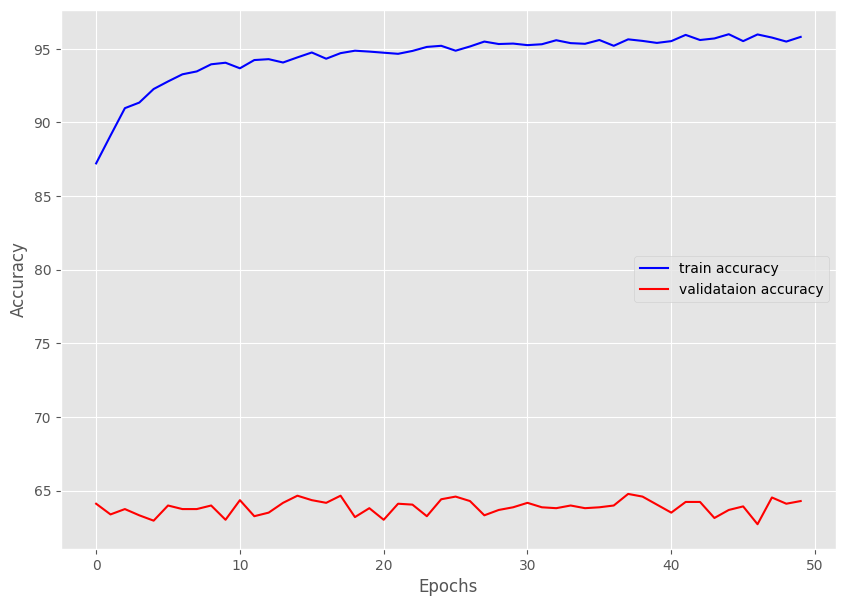

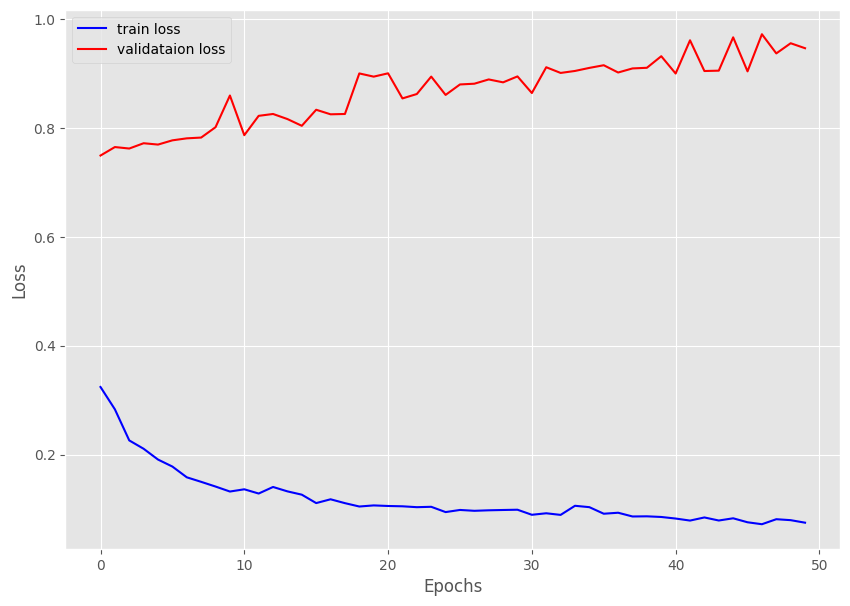

In [ ]:
save_plots(train_acc, valid_acc, train_loss, valid_loss)

In [16]:
trained_model = torch.load('model_49.pth')

FileNotFoundError: [Errno 2] No such file or directory: 'model_49.pth'

In [ ]:
def validate1(model, testloader, criterion, device):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    # y_true_v, y_pred_v = [], []
    # val_class_correct = list(0. for i in range(classes))
    # val_class_total = list(0. for i in range(classes))

    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            inputs, labels = data['text'], data['label']
            inputs = inputs.to(device)
            labels = labels.to(device).view(-1)
            # Forward pass.
            outputs1 = model(inputs)
            outputs = outputs1.view(-1, classes)

            # Calculate the loss.
            loss = criterion(outputs, labels)

            valid_running_loss += loss.item()
            preds = torch.argmax(outputs1,1)
            valid_running_correct += (preds == labels).sum().item()
            # correct  = (preds == labels).squeeze()
            # for a in range(len(preds)):
            #     label = labels[a]
            #     # print(label)
            #     val_class_correct[label] += correct[a].item()
            #     val_class_total[label] += 1

            # y_true_v.extend([int(item) for item in labels])
            # y_pred_v.extend([int(item) for item in preds])

    # Loss and accuracy for the complete epoch.
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    # epoch_accuracy = metrics.accuracy_score(y_true_v, y_pred_v)


    # for i in range(classes):
    #     print(f"Accuracy of class {classes[i]}: {100*val_class_correct[i]/val_class_total[i]}")
    # print('\n')



    return epoch_loss, epoch_acc#, epoch_accuracy

In [ ]:
test_loss, test_acc = validate1(
    trained_model,
    test_loader,
    criterion,
    device
)

print(f"Test loss: {test_loss}, test acc: {test_acc}")

Validation


  0%|          | 0/65 [00:00<?, ?it/s]

Test loss: 0.27398252464257755, test acc: 90.23357134212756


In [ ]:
def return_int_vector(int_mapping, text):
        """
        Assign an integer to each word and return the integers in a list.
        """
        corpus = [
            word for word in text.split()
        ]
        # Each word is replaced by a specific integer.
        int_vector = [
            int_mapping[word] for word in text.split() \
            if word in int_mapping
        ]
        return int_vector

In [ ]:
def pad_features(int_vector, max_len):
    """
    Return features of `int_vector`, where each vector is padded
    with 0's or truncated to the input seq_length. Return as Numpy
    array.
    """
    features = np.zeros((1, max_len), dtype = int)
    if len(int_vector) <= max_len:
        zeros = list(np.zeros(max_len - len(int_vector)))
        new = zeros + int_vector
    else:
        new = int_vector[: max_len]
    features = np.array(new)
    return features

In [ ]:
ress = []
for sentence in tqdm(data_test['text']):
    # print(sentence)
    res = {}
    res['text'] = sentence
    # print(res['text'])
    int_vector = return_int_vector(int_mapping, sentence)
    padded_features = pad_features(int_vector, int(longest_test))
    input_tensor = torch.tensor(padded_features, dtype=torch.int32)
    input_tensor = input_tensor.unsqueeze(0)
    output = trained_model(input_tensor.to(device))
    preds = torch.argmax(output)
    # print(preds)
    if preds == 1:
                  label = 'positive'
    elif preds == 0:
                  label = 'negative'
    else:
                  label = 'neutral'
    res['sentiment'] = label
    ress.append(res)

  0%|          | 0/2056 [00:00<?, ?it/s]

In [ ]:
itog = pd.DataFrame.from_dict(ress)
itog

,text,sentiment
0,"Как сообщает пресс-служба акимата Алматы, для ...",positive
1,Казахстанские авиакомпании перевозят 250 тысяч...,positive
2,На состоявшемся под председательством Касым-Жо...,neutral
3,В ОАЭ состоялись переговоры между казахстанско...,positive
4,12 вагонов грузового поезда сошли с путей в Во...,negative
...,...,...
2051,На официальной странице общественного движения...,neutral
2052,"официальный курс – 330,55 тенге за Доллар США ...",positive
2053,"«Базовая ставка, которая сейчас составляет 12%...",positive
2054,На начальном этапе за неоплату парковки на при...,positive


In [ ]:
itog.value_counts("sentiment")

sentiment
neutral     1467
positive     526
negative      63
dtype: int64

In [ ]:
from torchtext.vocab import GloVe

class GloveModel(nn.Module):
    def __init__(self, max_len, embed_dim, classes):
        super(GloveModel, self).__init__()
        global_vectors = GloVe(name='6B', dim=embed_dim)
        glove_weights = torch.load(f".vector_cache/glove.6B.{embed_dim}d.txt.pt")
        self.embedding = nn.Embedding.from_pretrained(glove_weights[2])
        self.rnn = nn.GRU(embed_dim, max_len, batch_first=True)
        self.linear1 = nn.Linear(max_len, classes)
        self.hidden_dim = max_len
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.rnn(x)
        x = self.dropout(x)
        x = x.max(dim=1)[0]
        out = self.linear1(x)
        return out

In [ ]:
# emotion_map = {
#     'negative': 0,
#     'positive': 1,
#     'neutral': 2
# }

In [ ]:
EMBED_DIM = 50
model1 = GloveModel(
    MAX_LEN,
    EMBED_DIM, classes
).to(device)

.vector_cache/glove.6B.zip: 862MB [02:45, 5.21MB/s]                           
100%|█████████▉| 399999/400000 [00:17<00:00, 23176.75it/s]


In [ ]:
print(model1)
criterion1 = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(
    model1.parameters(),
    lr=0.001,
)
# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model1.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model1.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.\n")

GloveModel(
  (embedding): Embedding(400000, 50)
  (rnn): GRU(50, 511, batch_first=True)
  (linear1): Linear(in_features=511, out_features=3, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)
20,864,615 total parameters.
864,615 training parameters.



In [ ]:
epochs = 50
# Lists to keep track of losses and accuracies.
train_loss1, valid_loss1 = [], []
train_acc1, valid_acc1, t_acc1, v_acc1 = [], [], [], []
# Start the training.
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss,  train_epoch_acc, t_epoch_acc = train(model1, train_loader,
                                            optimizer1, criterion1, device)
    valid_epoch_loss, valid_epoch_acc, v_epoch_acc = validate(model1, valid_loader,
                                                criterion1, device)
    train_loss1.append(train_epoch_loss)
    valid_loss1.append(valid_epoch_loss)
    train_acc1.append(train_epoch_acc)
    t_acc1.append(t_epoch_acc)
    valid_acc1.append(valid_epoch_acc)
    v_acc1.append(v_epoch_acc)
    print(f"Training loss: {train_epoch_loss}, training acc: {train_epoch_acc}, train acc: {t_epoch_acc}")
    print(f"Validation loss: {valid_epoch_loss}, validation acc: {valid_epoch_acc}, val acc: {v_epoch_acc}")

    # Save model.
    torch.save(model1, f'./model1_{epoch}.pth')
    print('-'*50)

[INFO]: Epoch 1 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6307
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.09767107178385441, training acc: 95.40160338829224, train acc: 0.9540160338829224
Validation loss: 1.0243311661940355, validation acc: 61.80387409200968, val acc: 0.6180387409200968
--------------------------------------------------
[INFO]: Epoch 2 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6303
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.0986780644609378, training acc: 95.34109816971714, train acc: 0.9534109816971714
Validation loss: 1.0884087911018958, validation acc: 60.47215496368039, val acc: 0.6047215496368039
--------------------------------------------------
[INFO]: Epoch 3 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6308
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.09687140347579351, training acc: 95.41672969293602, train acc: 0.9541672969293602
Validation loss: 1.1885563043447642, validation acc: 60.41162227602905, val acc: 0.6041162227602905
--------------------------------------------------
[INFO]: Epoch 4 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6315
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.1004759483755781, training acc: 95.52261382544245, train acc: 0.9552261382544245
Validation loss: 1.1307191023459802, validation acc: 60.16949152542372, val acc: 0.6016949152542372
--------------------------------------------------
[INFO]: Epoch 5 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6293
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.10102175319424042, training acc: 95.18983512327938, train acc: 0.9518983512327939
Validation loss: 1.099861516402318, validation acc: 60.16949152542372, val acc: 0.6016949152542372
--------------------------------------------------
[INFO]: Epoch 6 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6297
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.10336793060056292, training acc: 95.2503403418545, train acc: 0.9525034034185449
Validation loss: 1.0522478085297804, validation acc: 60.77481840193705, val acc: 0.6077481840193705
--------------------------------------------------
[INFO]: Epoch 7 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6312
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.09206935834999268, training acc: 95.47723491151112, train acc: 0.9547723491151112
Validation loss: 1.1010469519175017, validation acc: 61.38014527845036, val acc: 0.6138014527845036
--------------------------------------------------
[INFO]: Epoch 8 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6313
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.0956328261213807, training acc: 95.4923612161549, train acc: 0.954923612161549
Validation loss: 1.1090079500125005, validation acc: 60.53268765133172, val acc: 0.6053268765133172
--------------------------------------------------
[INFO]: Epoch 9 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6309
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.09440325222049768, training acc: 95.43185599757979, train acc: 0.954318559975798
Validation loss: 1.175588534428523, validation acc: 59.62469733656174, val acc: 0.5962469733656174
--------------------------------------------------
[INFO]: Epoch 10 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6319
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.08809999018334426, training acc: 95.58311904401755, train acc: 0.9558311904401755
Validation loss: 1.1128715047469506, validation acc: 59.38256658595642, val acc: 0.5938256658595642
--------------------------------------------------
[INFO]: Epoch 11 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6312
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.09254826813076551, training acc: 95.47723491151112, train acc: 0.9547723491151112
Validation loss: 1.0649389028549194, validation acc: 59.987893462469735, val acc: 0.5998789346246973
--------------------------------------------------
[INFO]: Epoch 12 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6304
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.09324413387534711, training acc: 95.35622447436091, train acc: 0.9535622447436092
Validation loss: 1.1158055663108826, validation acc: 60.351089588377725, val acc: 0.6035108958837773
--------------------------------------------------
[INFO]: Epoch 13 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6311
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.08967472480323452, training acc: 95.46210860686735, train acc: 0.9546210860686735
Validation loss: 1.3384869190362783, validation acc: 58.595641646489106, val acc: 0.585956416464891
--------------------------------------------------
[INFO]: Epoch 14 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6307
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.09447430052722876, training acc: 95.40160338829224, train acc: 0.9540160338829224
Validation loss: 1.1369454448039715, validation acc: 60.23002421307506, val acc: 0.6023002421307506
--------------------------------------------------
[INFO]: Epoch 15 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6323
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.09064592557171217, training acc: 95.64362426259265, train acc: 0.9564362426259265
Validation loss: 1.1594466062692494, validation acc: 60.16949152542372, val acc: 0.6016949152542372
--------------------------------------------------
[INFO]: Epoch 16 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6299
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.09205611222065412, training acc: 95.28059295114204, train acc: 0.9528059295114204
Validation loss: 1.2992171140817494, validation acc: 58.65617433414043, val acc: 0.5865617433414043
--------------------------------------------------
[INFO]: Epoch 17 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6326
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.09257124525566514, training acc: 95.68900317652398, train acc: 0.9568900317652398
Validation loss: 1.1760801122738764, validation acc: 59.866828087167065, val acc: 0.5986682808716707
--------------------------------------------------
[INFO]: Epoch 18 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6322
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.09253930490320691, training acc: 95.62849795794888, train acc: 0.9562849795794888
Validation loss: 1.1852776683293855, validation acc: 59.866828087167065, val acc: 0.5986682808716707
--------------------------------------------------
[INFO]: Epoch 19 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6311
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.09419744089245796, training acc: 95.46210860686735, train acc: 0.9546210860686735
Validation loss: 1.106594796364124, validation acc: 60.53268765133172, val acc: 0.6053268765133172
--------------------------------------------------
[INFO]: Epoch 20 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6316
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.09273182192387489, training acc: 95.53774013008622, train acc: 0.9553774013008622
Validation loss: 1.1563895573982825, validation acc: 60.351089588377725, val acc: 0.6035108958837773
--------------------------------------------------
[INFO]: Epoch 21 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6306
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.09180599368678835, training acc: 95.38647708364847, train acc: 0.9538647708364847
Validation loss: 1.1635929025136507, validation acc: 59.9273607748184, val acc: 0.5992736077481841
--------------------------------------------------
[INFO]: Epoch 22 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6312
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.09292299271776126, training acc: 95.47723491151112, train acc: 0.9547723491151112
Validation loss: 1.1524987174914434, validation acc: 59.68523002421308, val acc: 0.5968523002421308
--------------------------------------------------
[INFO]: Epoch 23 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6314
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.09138604941276404, training acc: 95.50748752079868, train acc: 0.9550748752079867
Validation loss: 1.333945787869967, validation acc: 57.99031476997578, val acc: 0.5799031476997578
--------------------------------------------------
[INFO]: Epoch 24 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6324
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.09396468547101204, training acc: 95.65875056723642, train acc: 0.9565875056723643
Validation loss: 1.1450925515248225, validation acc: 60.47215496368039, val acc: 0.6047215496368039
--------------------------------------------------
[INFO]: Epoch 25 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6300
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.09318479859771636, training acc: 95.29571925578581, train acc: 0.9529571925578582
Validation loss: 1.2373831180425792, validation acc: 59.80629539951574, val acc: 0.5980629539951574
--------------------------------------------------
[INFO]: Epoch 26 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6309
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.09082011462977299, training acc: 95.43185599757979, train acc: 0.954318559975798
Validation loss: 1.091935579593365, validation acc: 60.89588377723971, val acc: 0.6089588377723971
--------------------------------------------------
[INFO]: Epoch 27 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6315
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.09049707941281107, training acc: 95.52261382544245, train acc: 0.9552261382544245
Validation loss: 1.059647954427279, validation acc: 61.561743341404366, val acc: 0.6156174334140436
--------------------------------------------------
[INFO]: Epoch 28 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6306
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.09800458935877451, training acc: 95.38647708364847, train acc: 0.9538647708364847
Validation loss: 1.1596929339262156, validation acc: 59.80629539951574, val acc: 0.5980629539951574
--------------------------------------------------
[INFO]: Epoch 29 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6309
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.09500125064872779, training acc: 95.43185599757979, train acc: 0.954318559975798
Validation loss: 1.141639741567465, validation acc: 60.83535108958837, val acc: 0.6083535108958837
--------------------------------------------------
[INFO]: Epoch 30 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6339
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.08429334549090037, training acc: 95.88564513689306, train acc: 0.9588564513689306
Validation loss: 1.175967982182136, validation acc: 61.138014527845044, val acc: 0.6113801452784504
--------------------------------------------------
[INFO]: Epoch 31 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6326
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.09096281069259231, training acc: 95.68900317652398, train acc: 0.9568900317652398
Validation loss: 1.2519071514789875, validation acc: 59.62469733656174, val acc: 0.5962469733656174
--------------------------------------------------
[INFO]: Epoch 32 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6310
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.09282100834668829, training acc: 95.44698230222357, train acc: 0.9544698230222357
Validation loss: 1.1443407443853526, validation acc: 60.95641646489104, val acc: 0.6095641646489104
--------------------------------------------------
[INFO]: Epoch 33 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6327
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.08657028078316496, training acc: 95.70412948116775, train acc: 0.9570412948116775
Validation loss: 1.2040019585536077, validation acc: 59.866828087167065, val acc: 0.5986682808716707
--------------------------------------------------
[INFO]: Epoch 34 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6309
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.08176021163280194, training acc: 95.43185599757979, train acc: 0.954318559975798
Validation loss: 1.193205122764294, validation acc: 59.866828087167065, val acc: 0.5986682808716707
--------------------------------------------------
[INFO]: Epoch 35 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6323
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.0880215298026227, training acc: 95.64362426259265, train acc: 0.9564362426259265
Validation loss: 1.2494454567249005, validation acc: 59.14043583535109, val acc: 0.5914043583535109
--------------------------------------------------
[INFO]: Epoch 36 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6350
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.08527732300213896, training acc: 96.0520344879746, train acc: 0.9605203448797459
Validation loss: 1.2255761394133935, validation acc: 59.68523002421308, val acc: 0.5968523002421308
--------------------------------------------------
[INFO]: Epoch 37 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6334
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.08182839644499697, training acc: 95.81001361367419, train acc: 0.9581001361367418
Validation loss: 1.251518964767456, validation acc: 59.62469733656174, val acc: 0.5962469733656174
--------------------------------------------------
[INFO]: Epoch 38 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6323
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.08482719175159358, training acc: 95.64362426259265, train acc: 0.9564362426259265
Validation loss: 1.2094237345915575, validation acc: 59.50363196125908, val acc: 0.5950363196125908
--------------------------------------------------
[INFO]: Epoch 39 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6322
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.08301639911503746, training acc: 95.62849795794888, train acc: 0.9562849795794888
Validation loss: 1.251113772392273, validation acc: 59.50363196125908, val acc: 0.5950363196125908
--------------------------------------------------
[INFO]: Epoch 40 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6338
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.08039946327559076, training acc: 95.87051883224929, train acc: 0.9587051883224929
Validation loss: 1.2745874111468976, validation acc: 59.38256658595642, val acc: 0.5938256658595642
--------------------------------------------------
[INFO]: Epoch 41 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6321
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.08529152803552839, training acc: 95.61337165330511, train acc: 0.956133716533051
Validation loss: 1.1949858711316035, validation acc: 58.83777239709443, val acc: 0.5883777239709443
--------------------------------------------------
[INFO]: Epoch 42 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6306
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.08558120324204747, training acc: 95.38647708364847, train acc: 0.9538647708364847
Validation loss: 1.2059513192910414, validation acc: 60.048426150121074, val acc: 0.6004842615012107
--------------------------------------------------
[INFO]: Epoch 43 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6321
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.08438499887975362, training acc: 95.61337165330511, train acc: 0.956133716533051
Validation loss: 1.2055740356445312, validation acc: 59.68523002421308, val acc: 0.5968523002421308
--------------------------------------------------
[INFO]: Epoch 44 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6345
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.08482802981654039, training acc: 95.97640296475572, train acc: 0.9597640296475571
Validation loss: 1.311310419669518, validation acc: 59.261501210653755, val acc: 0.5926150121065376
--------------------------------------------------
[INFO]: Epoch 45 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6328
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.08368199282827285, training acc: 95.71925578581153, train acc: 0.9571925578581153
Validation loss: 1.2486352370335505, validation acc: 59.50363196125908, val acc: 0.5950363196125908
--------------------------------------------------
[INFO]: Epoch 46 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6345
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.0835688890566906, training acc: 95.97640296475572, train acc: 0.9597640296475571
Validation loss: 1.2982542698199933, validation acc: 59.56416464891041, val acc: 0.5956416464891041
--------------------------------------------------
[INFO]: Epoch 47 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6327
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.0760798526641268, training acc: 95.70412948116775, train acc: 0.9570412948116775
Validation loss: 1.2979786854523878, validation acc: 58.111380145278446, val acc: 0.5811138014527845
--------------------------------------------------
[INFO]: Epoch 48 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6327
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.08295965431114802, training acc: 95.70412948116775, train acc: 0.9570412948116775
Validation loss: 1.2530354536496675, validation acc: 60.16949152542372, val acc: 0.6016949152542372
--------------------------------------------------
[INFO]: Epoch 49 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6349
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.07914200813796085, training acc: 96.03690818333081, train acc: 0.9603690818333082
Validation loss: 1.3309802550535936, validation acc: 59.80629539951574, val acc: 0.5980629539951574
--------------------------------------------------
[INFO]: Epoch 50 of 50
Training


  0%|          | 0/52 [00:00<?, ?it/s]

train_running_correct 6342
Validation


  0%|          | 0/13 [00:00<?, ?it/s]

Training loss: 0.08013866064496912, training acc: 95.93102405082439, train acc: 0.9593102405082439
Validation loss: 1.3054400590749888, validation acc: 59.32203389830508, val acc: 0.5932203389830508
--------------------------------------------------


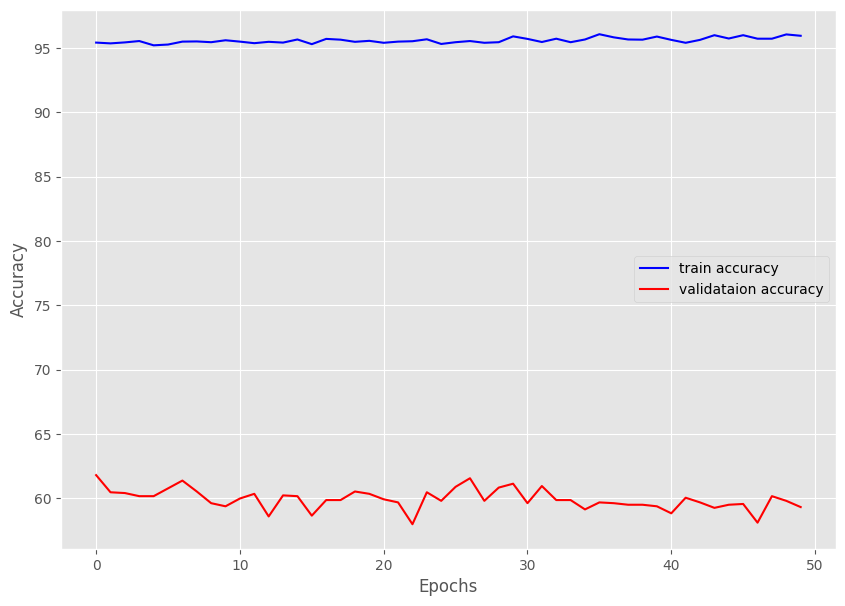

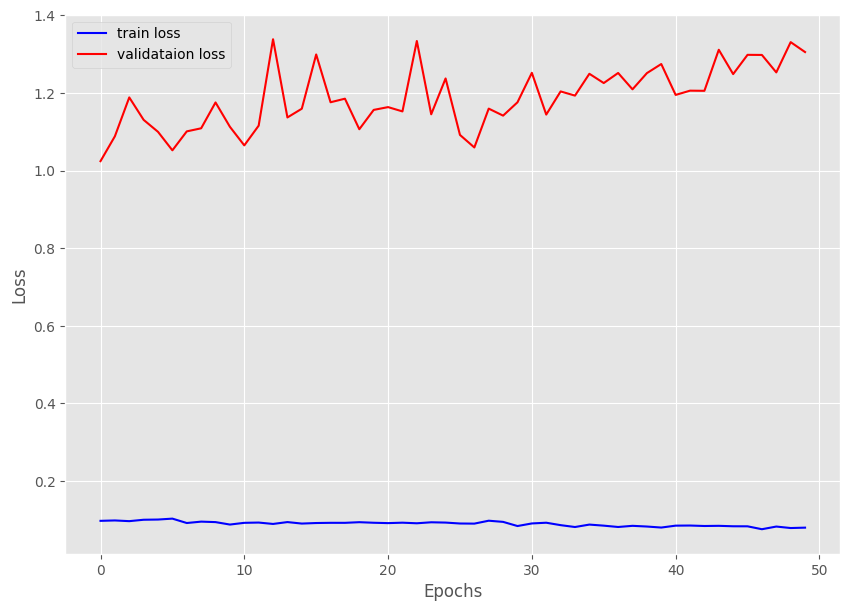

In [ ]:
save_plots(train_acc1, valid_acc1, train_loss1, valid_loss1)

In [ ]:
trained_model1 = torch.load('model1_49.pth')

In [ ]:
test_loss1, test_acc1, _ = validate(
    trained_model1,
    test_loader,
    criterion1,
    device
)

print(f"Test loss: {test_loss1}, test acc: {test_acc1}")

Validation


  0%|          | 0/65 [00:00<?, ?it/s]

Test loss: 0.31527656133358295, test acc: 89.24119569163742


In [ ]:
ress1 = []
for sentence in tqdm(data_test['text']):
    # print(sentence)
    res = {}
    res['text'] = sentence
    # print(res['text'])
    int_vector = return_int_vector(int_mapping, sentence)
    padded_features = pad_features(int_vector, int(longest_test))
    input_tensor = torch.tensor(padded_features, dtype=torch.int32)
    input_tensor = input_tensor.unsqueeze(0)
    output = trained_model1(input_tensor.to(device))
    preds = torch.argmax(output)
    # print(preds)
    if preds == 1:
                  label = 'positive'
    elif preds == 0:
                  label = 'negative'
    else:
                  label = 'neutral'
    res['sentiment'] = label
    ress1.append(res)

  0%|          | 0/2056 [00:00<?, ?it/s]

In [ ]:
itog1 = pd.DataFrame.from_dict(ress1)
itog1

,text,sentiment
0,"Как сообщает пресс-служба акимата Алматы, для ...",positive
1,Казахстанские авиакомпании перевозят 250 тысяч...,neutral
2,На состоявшемся под председательством Касым-Жо...,negative
3,В ОАЭ состоялись переговоры между казахстанско...,positive
4,12 вагонов грузового поезда сошли с путей в Во...,neutral
...,...,...
2051,На официальной странице общественного движения...,neutral
2052,"официальный курс – 330,55 тенге за Доллар США ...",neutral
2053,"«Базовая ставка, которая сейчас составляет 12%...",neutral
2054,На начальном этапе за неоплату парковки на при...,neutral


In [ ]:
itog1.value_counts("sentiment")

sentiment
neutral     1392
positive     548
negative     116
dtype: int64

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 49.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 90.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.0 MB/s eta 0:00:00


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
# from torch.utils.data import TensorDataset, DataLoader

# nltk.download('stopwords')
# nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased', do_lower_case=True)
model11 = BertForSequenceClassification.from_pretrained('bert-base-multilingual-uncased', num_labels = 3)

In [ ]:
print(model11)
criterion11 = nn.CrossEntropyLoss()
optimizer11 = optim.Adam(
    model11.parameters(),
    lr=0.001,
)
# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model11.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model11.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.\n")

In [ ]:
epochs = 50
# Lists to keep track of losses and accuracies.
train_loss11, valid_loss11 = [], []
train_acc11, valid_acc11, t_acc11, v_acc11 = [], [], [], []
# Start the training.
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss,  train_epoch_acc, t_epoch_acc = train(model11, train_loader,
                                            optimizer11, criterion11, device)
    valid_epoch_loss, valid_epoch_acc, v_epoch_acc = validate(model11, valid_loader,
                                                criterion11, device)
    train_loss11.append(train_epoch_loss)
    valid_loss11.append(valid_epoch_loss)
    train_acc11.append(train_epoch_acc)
    t_acc11.append(t_epoch_acc)
    valid_acc11.append(valid_epoch_acc)
    v_acc11.append(v_epoch_acc)
    print(f"Training loss: {train_epoch_loss}, training acc: {train_epoch_acc}, train acc: {t_epoch_acc}")
    print(f"Validation loss: {valid_epoch_loss}, validation acc: {valid_epoch_acc}, val acc: {v_epoch_acc}")

    # Save model.
    torch.save(model11, f'./model11_{epoch}.pth')
    print('-'*50)

In [65]:
trained_model  = RNN_GRU_CH_Attention(vocab_size, emb_dim, hidden, n_classes, n_chars, char_emb, char_hid).to(device)
checkpoint = torch.load('rnn_chkpt_4.pth', map_location=device)
trained_model.load_state_dict(checkpoint)#['model_state_dict'])

<All keys matched successfully>

In [66]:
trained_model

RNN_GRU_CH_Attention(
  (word_emb): Embedding(324758, 256)
  (rnn): GRU(320, 256, batch_first=True)
  (clf): Linear(in_features=512, out_features=3, bias=True)
  (do): Dropout(p=0.2, inplace=False)
  (char_rnn): CharRNN_GRU(
    (char_emb): Embedding(315, 32)
    (rnn): GRU(32, 64, batch_first=True)
  )
  (attn): Attention_net(
    (dropout): Dropout(p=0.1, inplace=False)
    (softmax): Softmax(dim=2)
  )
)

In [99]:
data_test['text'][1074]

'Казахстанские авиакомпании перевозят 250 тысяч транзитных пассажиров в год  со ссылкой на пресс-службу Министерства по инвестициям и развитию.  \n\n«В настоящее время отечественными авиакомпаниями через территорию Казахстана перевозится 250 тысяч транзитных пассажиров в год, что в 10 раз больше показателя 2010 года. В среднем около 70 процентов всех транзитных пассажиров приходится на столичный аэропорт. Это 175 тысяч транзитных пассажиров приходится на Астану и 75 тысяч на Алматы», — об этом заявил министр по инвестициям и развитию РК Женис Касымбек, выступая на заседании правительства. \n\nДальнейшему росту транзита  авиапассажиров будет способствовать реализация проекта строительства терминала аэропорта Астаны, создания хаба под Алматы, развитие международных маршрутов и казахстанских авиакомпаний. Наиболее перспективными направлениями транзита являются пассажиропоток из стран Юго-Восточной Азии, Китая и Индии. \n\nКак отметил министр, авиакомпанией «Эйр Астана» планируется расшире

In [155]:
trained_model.eval()
sentence = data_test['text'][1074]
words = sentence.split(' ')
tokens = []
chars1 = []
for w in words:
        try:
            tokens.append(dataset.word_vocab[w])
        except:
            tokens.append(0)                    
tokens = torch.tensor(tokens).unsqueeze(0).to(device)
for w in words:
        chars12 = []
        for c in w:
                try:
                    chars12.append(dataset.char_vocab[c])
                except:
                    chars12.append(0)
        chars1.append(chars12)

chars1 = list(map(lambda x: x if len(x) != 0 else [0], chars1))
chars = [torch.tensor(w).unsqueeze(0).to(device) for w in chars1]
predict = trained_model(tokens, chars) # 1 x T x N_classes
labels = torch.argmax(predict, dim=-1).squeeze().cpu().detach().tolist()
labels

1

In [156]:
n = 0
m = 0
trained_model.eval()
ress = []
for sentence in tqdm(data_test['text']):
    # print(sentence)
    res = {}
    res['text'] = sentence
    words = sentence.split(' ')
    tokens = []
    chars1 = []
    for w in words:
            try:
                tokens.append(dataset.word_vocab[w])
            except:
                n +=1
                tokens.append(0)
    tokens = torch.tensor(tokens, dtype=torch.long).unsqueeze(0).to(device)
    for w in words:
        chars12 = []
        for c in w:
                try:
                    chars12.append(dataset.char_vocab[c])
                except:
                    m +=1
                    chars12.append(0)
        chars1.append(chars12)
        #     chars1 = [[dataset.char_vocab[c] for c in w] for w in words]
    
    chars1 = list(map(lambda x: x if len(x) != 0 else [0], chars1))
    chars = [torch.tensor(w, dtype=torch.long).unsqueeze(0).to(device) for w in chars1]
    predict = trained_model(tokens, chars) # 1 x T x N_classes
    labels = torch.argmax(predict, dim=-1).squeeze().cpu().detach().tolist()
    # print(preds)
    if labels == 1:
                  label = 'positive'
    elif labels == 0:
                  label = 'negative'
    else:
                  label = 'neutral'
    res['sentiment'] = label
    ress.append(res)
print(n, m)

  0%|          | 0/2056 [00:00<?, ?it/s]

1


In [158]:
itog = pd.DataFrame.from_dict(ress)
itog

,text,sentiment
0,"Как сообщает пресс-служба акимата Алматы, для ...",positive
1,Казахстанские авиакомпании перевозят 250 тысяч...,neutral
2,На состоявшемся под председательством Касым-Жо...,negative
3,В ОАЭ состоялись переговоры между казахстанско...,positive
4,12 вагонов грузового поезда сошли с путей в Во...,negative
...,...,...
2051,На официальной странице общественного движения...,neutral
2052,"официальный курс – 330,55 тенге за Доллар США ...",neutral
2053,"«Базовая ставка, которая сейчас составляет 12%...",positive
2054,На начальном этапе за неоплату парковки на при...,neutral


In [159]:
itog.value_counts("sentiment")

sentiment
neutral     1245
positive     448
negative     363
dtype: int64